# Introduction to Amazon S3

## What is Amazon S3?

- Amazon Simple Storage Service (S3) is an **object storage service** 
- designed to store and retrieve **any amount** of data from **anywhere** on the internet. 
- It provides industry-leading scalability, data availability, security, and performance.
- simple interface for developers

## Key Characteristics

| Characteristic | Description |
|----------------|-------------|
| **Scalability** | Virtually unlimited storage capacity |
| **Durability** | 99.999999999% (11 9's) durability |
| **Availability** | Up to 99.99% availability depending on storage class |
| **Simple Interface** | **RESTful API** for developers |

## Common Use Cases

| Use Case | Description |
|----------|-------------|
| **Backup & Storage** | Store backups of databases, applications, and files |
| **Data Lake** | Central repository for structured and unstructured data for analytics |
| **Disaster Recovery (DR)** | Store copies of critical data in different regions |
| **Archive** | Long-term storage of compliance and historical data |
| **Static Website Hosting** | Host static HTML, CSS, JS files |
| **Application Data** | Store user uploads, logs, media files |

## What S3 is NOT

Understanding what S3 cannot do is crucial:

| Limitation | Explanation |
|------------|-------------|
| **Not a Database** | Cannot perform SQL queries directly on data (use Athena for that) |
| **Not a File System** | No traditional directory hierarchy with inodes |
| **No Row-Level Operations** | Cannot update a single row in a CSV file |
| **No UPDATE or DELETE WHERE** | Must replace entire objects to modify data |





## Core Concepts

### 1. Buckets

A **bucket** is the top-level container in S3 that holds objects.

- Globally unique name (across ALL AWS accounts)    
- Created in a specific AWS region                  
- Contains objects (files) and their metadata       
- Flat structure (no real folders/directories)      

#### Bucket Naming Rules

| Rule | Valid | Invalid |
|------|-------|---------|
| Length | 3-63 characters | `ab` (too short), `a-very-long-bucket-name-that-exceeds-sixty-three-characters-total` |
| Case | Lowercase only | `MyBucket`, `BUCKET` |
| Start character | Lowercase letter or number | `_bucket`, `-bucket` |
| Characters allowed | Lowercase letters, numbers, hyphens | `my_bucket` (underscore), `my.bucket` (dots discouraged) |
| Prefix restriction | Cannot start with `xn--` | `xn--mybucket` |
| Suffix restriction | Cannot end with `-s3alias` | `mybucket-s3alias` |

**Example Naming Convention**:  
```text
    {company-id}-{environment}-{region}-{purpose}-{date}-{descriptor}

    Eg: acme-prod-us-east-1-datalake-2025-raw
```
 

#### Buckets Are NOT Directories
> This is a critical concept for interviews

- No real folders
- No directory hierarchy
- Only object keys

```text
    Traditional File System:          S3 "Illusion":
    ├── folder1/                      Objects with keys containing "/"
    │   ├── file1.txt                 
    │   └── subfolder/                key: "folder1/file1.txt"
    │       └── file2.txt             key: "folder1/subfolder/file2.txt"

    S3 Reality:
    ┌────────────────────────────────────────┐
    │ Flat namespace with keys:              │
    │ • "folder1/file1.txt"                  │
    │ • "folder1/subfolder/file2.txt"        │
    │ (The "/" is just part of the key name) │
    └────────────────────────────────────────┘
```


### 2. Objects

- An **object** is the fundamental entity stored in S3, 
- consisting of data and metadata.
- Each object has a unique key

#### Object Components

```text
    ┌─────────────────────────────────────────────────────────────┐
    │                        OBJECT                               │
    ├─────────────────────────────────────────────────────────────┤
    │  DATA (Body)                                                │
    │  • The actual file content (binary or text)                 │
    │  • Maximum size: 5 TB                                       │
    │  • For files > 5 GB: Use multipart upload                   │
    ├─────────────────────────────────────────────────────────────┤
    │  METADATA                                                   │
    │  • System metadata: Content-Type, Last-Modified, etc.       │
    │  • User-defined metadata: Custom key-value pairs            │
    ├─────────────────────────────────────────────────────────────┤
    │  KEY                                                        │
    │  • Unique identifier within the bucket                      │
    │  • Full path: prefix + object name                          │
    └─────────────────────────────────────────────────────────────┘
```

#### Object Size Limits

| Upload Method | Size Limit | When to Use |
|---------------|------------|-------------|
| Single PUT | 5 GB max | Small files |
| Multipart Upload | 5 TB max | Files > 100 MB recommended |

<img src="./pic/4_multipart_upload.png" width=400>



### 3. Keys

- The **key** is the unique identifier for an object within a bucket.
- Each object has a unique key
- The key is the full s3 path: Prefix + '/' + object name  

'/':  slash

#### Key Structure   
```text
    s3://{bucket-name}/{key}
    s3://{bucket-name}/{prefix}/{object-name}

    Example:
    s3://angel-test-demo/test1/sub-test/bigdata.csv
        └─────────────┘ └────────────┘ └────────┘
            Bucket         Prefix      Object Name
                        └─────────────────────────┘
                                Key
```



### 4. Prefixes

A **prefix** is the portion of the key before the object name, simulating folder structure.

**Why Prefixes Matter for Spark/Hive Performance**:  

- Without proper prefixes (BAD):    
    ```text
        s3://bucket/file1.csv
        s3://bucket/file2.csv
        s3://bucket/file3.csv
    ```
    → All files in one "directory" = single partition scan    

- With proper prefixes (GOOD):     
    ```text
        s3://bucket/year=2024/month=01/data.parquet
        s3://bucket/year=2024/month=02/data.parquet
        s3://bucket/year=2025/month=01/data.parquet
    ```
    → Partition pruning possible = read only needed partitions

**Prefix Best Practices**:   

| Practice | Benefit |
|----------|---------|
| Date-based partitioning | `raw/year=2024/month=01/day=15/` enables time-based queries |
| Hash prefixes | Distribute load across S3 partitions for high-throughput |
| Logical grouping | `bronze/`, `silver/`, `gold/` for data lake layers |

# S3 Security Model

## Overview
S3 security operates on two main mechanisms that work together:  
1. **User-based permissions**
  - IAM user / role policies (attached to users/roles)
2. **Resource-based permissions**
  - **Bucket Policies** (Primary & Recommended)
  - **Access Points Policies** 
  - **Object ACLs** (optional)
    - Attached to individual objects
    - **fine-grained**: very precise, detailed control over access, not just who can access something, but exactly what they can do, on which resource, and under what conditions
  	- Grants access to:
    	- Specific AWS accounts
    	- Predefined groups (e.g., AuthenticatedUsers)
  	- Legacy feature
    	- ❌ No conditions
    	- ❌ Hard to manage at scale
  	- ⚠️ **Disabled by default** when Object Ownership = Bucket owner enforced
  - **Bucket ACLs**
    - Attached to the bucket
	  - Very limited permissions (READ / WRITE)
	  - Mainly used for:
  	  - Log delivery (historical reason)
	  - ❌ No fine-grained control
    - ⚠️ Strongly discouraged
  


Object ACLs and Bucket ACLs are “Old”, legacy mechanisms   

AWS now recommends using policies instead:
- Bucket policies
- Access point policies
- IAM identity policies

Since S3 Object Ownership → Bucket owner enforced:
- ACLs are disabled by default
- ACL permissions are ignored

## IAM Policies

**User-based** permissions attached to IAM users, groups, or roles.

### Example IAM Policy
```json
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": [
        "s3:GetObject",
        "s3:PutObject"
      ],
      "Resource": "arn:aws:s3:::my-bucket/*"
    }
  ]
}
```

### Use Cases
- Grant specific users/roles access to S3
- Centralized permission management through IAM
- Cross-service permissions (EC2 instance accessing S3)



## Bucket Policies

- **Resource-based** policies attached directly to the bucket.
- JSON-based
- Supports:
    - **Fine-grained** permissions
    - Conditions (IP, VPC endpoint, TLS, etc.)
    - Cross-account access
  - Best practice for almost all use cases
- ✅ Most powerful & scalable

#### Example Bucket Policy
```json
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "AWS": "arn:aws:iam::123456789012:root"
      },
      "Action": "s3:GetObject",
      "Resource": "arn:aws:s3:::my-bucket/*"
    }
  ]
}
```

### Use Cases
- Cross-account access
- Public access (with caution!)
- Enforce encryption requirements
- IP-based restrictions



## Access Point Policies

Simplify security management for buckets with many **different access patterns**.  

- Named network endpoints for a bucket
- Each access point has its **own resource policy**
- This policy is **attached directly to the access point, not the bucket**.
- Can:
  - Restrict access to specific VPCs
  - Simplify access for different applications/teams
- ✅ Modern, scalable alternative to complex bucket policies

<img src='./pic/4_access_point_example.png' width=500>

### What are Access Points?

Access Points are named network endpoints attached to buckets, simplifying data access management at scale. 

- every Amazon S3 access point is a **unique network endpoint** with its own dedicated DNS name, distinct from the main bucket's DNS. 
- This allows you to route traffic to the same bucket through different "doors" (access points), each with its own customized access policy and network controls (like VPC-only access). 

```text
┌────────────────────────────────────────────────────────────┐
│                    WITHOUT ACCESS POINTS                   │
│  ┌──────────────────────────────────────────────────────┐  │
│  │                   S3 BUCKET                          │  │
│  │          One complex bucket policy                   │  │
│  │   managing access for finance, sales, analytics...   │  │
│  └──────────────────────────────────────────────────────┘  │
│                           │                                │
│         ┌─────────────────┼─────────────────┐              │
│         ▼                 ▼                 ▼              │
│     Finance           Sales           Analytics            │
│                                                            │
├────────────────────────────────────────────────────────────┤
│                    WITH ACCESS POINTS                      │
│  ┌──────────────────────────────────────────────────────┐  │
│  │                   S3 BUCKET                          │  │
│  │  ┌──────────┐  ┌──────────┐  ┌──────────┐            │  │
│  │  │ /finance │  │ /sales   │  │/analytics│            │  │
│  │  └─────┬────┘  └────┬─────┘  └────┬─────┘            │  │
│  └────────┼────────────┼─────────────┼──────────────────┘  │
│           │            │             │                     │
│           ▼            ▼             ▼                     │
│  ┌──────────────┐ ┌──────────────┐ ┌──────────────┐        │
│  │ Finance AP   │ │ Sales AP     │ │ Analytics AP │        │
│  │ Own policy   │ │ Own policy   │ │ Own policy   │        │
│  │ Own DNS      │ │ Own DNS      │ │ Own DNS      │        │
│  └──────┬───────┘ └──────┬───────┘ └──────┬───────┘        │
│         │                │                │                │
│         ▼                ▼                ▼                │
│     Finance           Sales           Analytics            │
│     Team              Team            Team                 │
└────────────────────────────────────────────────────────────┘
```

#### Access Point Features

| Feature | Description |
|---------|-------------|
| **Own DNS Name** | Each AP has unique endpoint |
| **Own Policy** | Simplified, scoped permissions |
| **VPC Restriction** | Can restrict to specific VPC |
| **Internet or VPC** | Choose origin type |

#### Access Point DNS Format

Unlike the standard bucket URL (`bucket-name.s3.region.amazonaws.com`), an access point URL includes the **access point name**, the **AWS Account ID**, and the **Region**. Example DNS Format:   

`[AccessPointName]-[AccountID].s3-accesspoint.[Region].amazonaws.com`


#### Use Cases

1. **Multi-tenant applications**: Separate access points per tenant
2. **Security isolation**: VPC-only access points for internal apps
3. **Simplified management**: Replace complex bucket policies
4. **Compliance**: Different access points for different compliance requirements

### Access Point Policy Examples:   

**Departmental Isolation**  

A single S3 bucket can stores data for multiple departments. We create a dedicated access point for the "Finance" team that only allows them to access their specific folder. The Access Point DNS:   
- Access Point Name: finance-ap
- Account ID: 123456789012
- Region: us-east-1
- Resulting DNS: `finance-ap-123456789012.s3-accesspoint.us-east-1.amazonaws.com`
  
  <img src='./pic/4_access_point_eg_department.png' width=500>


It allows only the "FinanceRole" to perform actions through this specific DNS endpoint:  

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::123456789012:role/FinanceRole"
            },
            "Action": ["s3:GetObject", "s3:ListBucket"],
            "Resource": [
                "arn:aws:s3:us-east-1:123456789012:accesspoint/finance-ap",
                "arn:aws:s3:us-east-1:123456789012:accesspoint/finance-ap/object/finance-data/*"
            ]
        }
    ]
}
```

**User Isolation**   

<img src='./pic/4_access_point_eg_person.png' width=400>


### Benefits
- Each access point has its own DNS name, distinct from the main bucket's DNS
- Independent policy per access point
- Can be Internet-facing or VPC-only
  - can configure an access point to accept requests only from a specific VPC, creating a private DNS endpoint for your internal data
- Scales security management for large organizations
  - can have up to 10,000 access points per region per account
- S3 also generates an **access point alias** (e.g., my-ap-hrzrl...-s3alias) that can be used **in place of a bucket name** in many AWS CLI and SDK operations





## Policy Comparison Table

| Aspect | IAM Policy | Bucket Policy | Access Point Policy |
|--------|-----------|---------------|---------------------|
| **Attached to** | Users/Roles | Bucket | Access Point |
| **Scope** | User's permissions | Bucket-wide | Specific access pattern |
| **Principal** | Implicit (attached user) | Explicit (who can access) | Explicit |
| **Cross-account** | Need both IAM + Bucket | Can grant directly | Can grant directly |
| **Best for** | Internal user management | Public access, cross-account | Large-scale multi-tenant |



## Permission Evaluation Rules

CRITICAL RULE: **Explicit DENY** always wins!

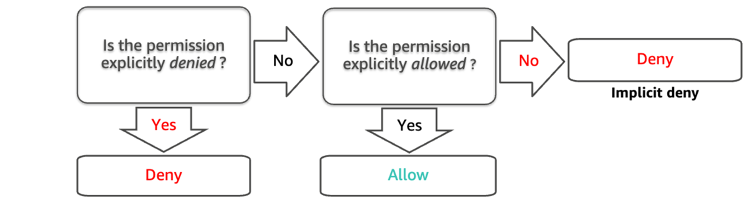


# S3 Versioning

Versioning keeps **multiple variants of an object** in the same bucket, enabling recovery from unintended user actions and application failures. 
- **Overwriting** the same object key creates **a new version**
- **Deleting** an object adds a **delete marker**
- Old versions are preserved unless explicitly removed


```text
     WITHOUT VERSIONING:                WITH VERSIONING:
     ┌─────────────┐                   ┌─────────────────────────┐
     │ photo.gif   │                   │ photo.gif               │
     │             │    Overwrite      │ ├── Version ID: 111111  │
     │ Version: N/A│   ────────────►   │ ├── Version ID: 222222  │
     │             │                   │ └── Version ID: 333333  │
     └─────────────┘                   │     (latest)            │
          │                            └─────────────────────────┘
          │ Overwrite                           │
          ▼                                     │ Overwrite
     ┌─────────────┐                            ▼
     │ photo.gif   │                   New version added,
     │ (NEW DATA)  │                   old versions preserved
     │ OLD DATA    │
     │   LOST!     │
     └─────────────┘
```

## How Versioning Works

### Enabling Versioning
- Enabled at the **bucket level**
- Once enabled, cannot be disabled (only suspended)
- Objects uploaded before enabling have version ID "null"
- [official doc](https://docs.aws.amazon.com/AmazonS3/latest/userguide/manage-versioning-examples.html)

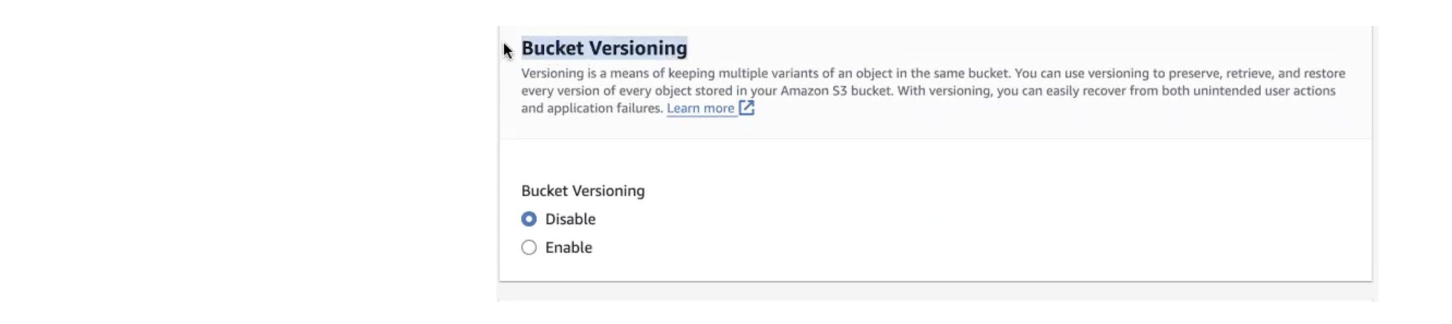

### Version IDs
- Each object version has a unique version ID
- Generated automatically by S3
- Used to retrieve specific versions

### Delete Behavior with Versioning

```text
     DELETE without version ID:          DELETE with version ID:
     ┌─────────────────────────┐        ┌─────────────────────────┐
     │ photo.gif               │        │ photo.gif               │
     │ ├── v1 (current)        │        │ ├── v1 ← PERMANENTLY    │
     │ └── v2                  │        │ └── v2   DELETED        │
     └───────────┬─────────────┘        └─────────────────────────┘
               │                      
               │ DELETE photo.gif     
               ▼                      
     ┌─────────────────────────┐        
     │ photo.gif               │        
     │ ├── Delete Marker ←NEW  │        
     │ ├── v1 (still exists)   │        
     │ └── v2 (still exists)   │        
     └─────────────────────────┘        
     Object appears deleted but
     can be recovered by removing
     the delete marker
```

## Problems Solved vs. Introduced

| Problem Solved | New Problem Introduced |
|----------------|----------------------|
| Accidental deletion recovery | Increased storage costs (all versions stored) |
| Accidental overwrite recovery | Complexity in managing versions |
| Audit trail of changes | Delete markers can accumulate |
| Ransomware protection 勒索软件防护 | Need lifecycle rules to manage old versions |

## Best Practices

1. **Enable versioning** on critical buckets
2. **Use lifecycle rules** to delete old versions after N days
3. **Enable MFA Delete** for extra protection on version deletion
4. **Monitor storage costs** as versions accumulate



# Disaster Recovery (DR)
Disaster Recovery = ability to **restore data and systems** after failures
Failures may include:
- Region outage
- Accidental deletion or corruption
- Account-level incidents

S3 Replication (CRR / SRR) is a data-level DR mechanism

## Goals
Amazon S3 Disaster Recovery (DR) centers on two primary goals: protecting against **regional outages** and preventing **data corruption or accidental deletion**.  

**1. Protection Against Regional Outages**   
For mission-critical workloads that must survive a full AWS region failure, the modern standard is a **multi-region architecture**.  

- **S3 Cross-Region Replication (CRR)**: Automatically and asynchronously copies every new object from a source bucket in one region to a destination bucket in another.
- **S3 Replication Time Control (RTC)**: For businesses with strict compliance needs, RTC guarantees that 99.99% of objects are replicated within 15 minutes, backed by a Service Level Agreement (SLA).
- **Multi-Region Access Points (MRAP)**: Provides a *single global DNS endpoint for your application*. In a disaster, AWS can automatically (or manually) route traffic away from a disrupted region to the replicated copy in the healthy region within minutes.
- **S3 Batch Replication**: Used to "backfill" or replicate existing objects that were in the bucket before replication rules were turned on. 

**2. Protection Against Data Corruption & Ransomware**  
Regional durability does not protect against someone accidentally deleting a file or a ransomware attack that encrypts it. 

- **Object Versioning**: Keeps multiple versions of an object in the same bucket. If a file is deleted or overwritten, you can simply roll back to a previous version.
- **S3 Object Lock**: Implements **"WORM" (Write-Once-Read-Many)** protection. This prevents objects from being deleted or overwritten by **anyone, including root users**, for **a fixed period**, providing a definitive defense **against ransomware**.
- **Cross-Account Replication**: Replicating data to a bucket in a different AWS account ensures that even if your primary account is fully compromised, your backup data remains inaccessible to the attacker. 


## Comparison of DR Strategies

| Strategy 	| RTO (Recovery Time)	| RPO (Recovery Point)	| Best For| 
| ----------| -----------------------| ---------------------| ---------| 
| Backup & Restore	| Hours to Days	| 24+ Hours	| Non-critical archives| 
| Pilot Light	| Minutes to Hours	| < 15 Minutes| 	Cost-conscious DR| 
| Warm Standby	| Minutes| 	Near Zero	| Mission-critical apps| 
| Multi-Region | Active-Active	| Seconds	| Near Zero	| Zero-downtime global apps| 


# S3 Replication

Replication automatically copies objects from a source bucket to one or more destination buckets. Replication is **asynchronous**.

There are two types of Replication: 
- SRR (Same-Region Replication) 
- CRR (Cross-Region Replication)

<img src='./pic/4_s3_replica_types.webp' width=400>  

## SRR vs CRR Comparison

| Aspect | SRR (Same-Region) | CRR (Cross-Region) |
|--------|-------------------|-------------------|
| **Region** | Same region | Different regions |
| **Latency** | Lower | Higher (cross-region transfer) |
| **Cost** | Lower (no inter-region transfer) | Higher (data transfer costs) |
| **Use Cases** | Log aggregation, compliance copies, dev/test | DR, compliance, latency reduction |

## Common Use Cases

### SRR Use Cases
1. **Log aggregation**: Combine logs from multiple source buckets
2. **Compliance**: Create copies in same region for legal hold
3. **Dev/Test environments**: Replicate production data for testing
4. **Data sovereignty**: Keep data within same region

### CRR Use Cases
1. **Disaster Recovery**: Survive entire region failure
2. **Compliance**: Meet regulations requiring geographic data copies
3. **Latency reduction**: Serve users from nearest region
4. **Cross-account separation**: Production bucket → Analytics account

## Replication Requirements

Prerequisites for Replication:

1. **Versioning** **MUST** be enabled on **both** source and          
   destination buckets                                     
                                                        
2. **IAM role** with proper permissions:                       
   - s3:GetReplicationConfiguration (source)               
   - s3:ListBucket (source)                                
   - s3:GetObjectVersionForReplication (source)            
   - s3:ReplicateObject (destination)                      
   - s3:ReplicateDelete (destination, if enabled)          
                                                        
3. Bucket owner must have **permissions on both** buckets      
                                                        
4. For cross-account: **destination bucket policy** must       
   allow the source account                                

## Important Features

- Source and Destination buckets can be within the **same AWS account** or across **different AWS accounts**. The default behavior is the same owner / AWS account for both the source and the destination.
- It is required to assign a **Role** to the source bucket since it interacts with a destination bucket. This is valid for both the same and different AWS account scenarios.
- A **bucket policy** should be defined at the **destination bucket level** if you are using *two different AWS accounts*. If it is the same AWS account this is not required since it is in the same AWS account, both source and destination buckets trust each other.
- **Replication Time Control (RTC)**: This **optional** feature is defined if you have a 15 minute window to replicate. This is an important feature to add, if you have strict **Service Level Agreement (SLA)** of 15 minute or less to meet for the Replication Time Control (RTC)
- Need to add a **replication configuration** to the **source bucket**. This replication configuration should include a **filter criteria** to replicate all or a subset of the source bucket contents.
- The replication does happen between one source and one destination. **Multiple destinations by a single source is not allowed.**
- You **can change** the storage class/ tier to a lesser class while doing the replication. The **default setting** is the **same storage class/ tier** for both source and destination buckets.
- Mostly destination bucket is chosen as a **S3-Zone1A**, where the use case is merely a backup.
- Both the un-encrypted and encrypted objects (SSE-S3 and SSE-KMS) are replicated. However, **objects encrypted with SSE-C are not replicated**
- It is always **one way replication only**.



## What is not replicated

- Objects **added before** the replication 
- The source bucket **sub level resources are not replicated**
- The objects, which were **created by another replication** activity 
- **System events** are not replicated (**only user events** are replicated)
- Objects in the Glacier and Glacier Deep Archive are not replicated
- Deleted objects are not replicated (objects marked with a delete marker are not replicated).

so Replication Behavior:  

| Behavior | Description |
|----------|-------------|
| **New objects only** | By default, only objects created after enabling replication |
| **Existing objects** | Require S3 Batch Replication for existing objects |
| **Delete markers** | Can optionally replicate delete markers |
| **Permanent deletes** | Not replicated (security feature) |
| **No chaining** | If A→B and B→C, objects in A don't go to C automatically |


# S3 Storage Classes

S3 offers different storage classes optimized **for different access patterns and cost requirements**.

## Storage Classes Comparison

| Storage Class | Description | Availability | Availability Zones (AZs) | Min Storage Duration Charge | Min BillableObj Size | Retrieval Fee | Best Use Case |
|--------------|-------------|--------------|-----|--------------|--------------|---------------|---------------|
| **Standard** | High performance, frequent access | 99.99% | ≥3 | None | None | None | **Real-time apps:** Websites, mobile gaming, and active big data analytics |
| **Intelligent-Tiering** | Auto-moves data between access tiers | 99.9% | ≥3 | None | None | None | **Data Lakes:** When access patterns are unknown or unpredictable |
| **Express One Zone** | Single-digit ms latency (Fastest) | 99.9% | 1 | None | None | None | **AI/ML Training:** High-performance computing and model training |
| **Standard-IA** | Infrequent access but rapid needs | 99.9% | ≥3 | 30 Days | 128KB | Per GB | **Disaster Recovery:** Storing "Warm Standby" data for instant recovery |
| **One Zone-IA** | Low cost, single-zone IA | 99.5% | 1 | 30 Days | 128KB | Per GB | **Secondary Backups:** Storing thumbnails or data that can be recreated |
| **Glacier Instant Retrieval** | Long-lived, millisecond access | 99.9% | ≥3 | 90 Days | 128KB | Per GB | **Medical Records:** Storing images (X-rays) that are rarely viewed but needed instantly |
| **Glacier Flexible Retrieval** | 1-2 times/year access | 99.99% | ≥3 | 90 Days | 40KB | Per GB | **Offsite Backups:** General archival data that can wait 3-5 hours for restoration |
| **Glacier Deep Archive** | Deep archival (Lowest cost) | 99.99% | ≥3 | 180 Days | 40KB | Per GB | **Regulatory Compliance:** Records kept for 7-10 years for legal/gov requirements |

### Key Insights

- **Availability decreases** as you move toward archival storage
- **Minimum storage duration** increases for archival classes (protecting against frequent data movement)
- **Retrieval fees** apply to all IA and Glacier tiers
- **One Zone** classes sacrifice redundancy for cost savings
- **Glacier tiers** have progressively longer minimum durations and lower costs
- **Lifecycle Policies**: You can **automate transitions** between these classes using S3 Lifecycle configurations to optimize costs as data ages.
- **Security**: S3 **Object Lock** and **Default Encryption** are standard features across all storage classes to prevent ransomware and data breaches.

### Durability

**All storage classes** provide **99.999999999% (11 9's) durability** 

This means: If you store 10,000,000 objects, you can expect to lose 1 object every 10,000 years.

### Glacier Retrieval Time Options

GLACIER FLEXIBLE RETRIEVAL
```text
    ┌─────────────────────────────────────────────────────────────┐
    │  Expedited    ████░░░░░░░░░░░░░░░░░░░░░░░░░░  1-5 minutes   │
    │                                                             │
    │  Standard     ████████████████░░░░░░░░░░░░░░  3-5 hours     │
    │                                                             │
    │  Bulk         ████████████████████████████░░  5-12 hours    │
    └─────────────────────────────────────────────────────────────┘
```

GLACIER DEEP ARCHIVE RETRIEVAL
```text
    ┌─────────────────────────────────────────────────────────────┐
    │  Standard     ████████████████████████░░░░░░  12 hours      │
    │                                                             │
    │  Bulk         ████████████████████████████░░  48 hours      │
    └─────────────────────────────────────────────────────────────┘
```

## Choosing the Right Storage Class

Decision Tree:
```text
    Is data accessed frequently (multiple times per month)?
    ├── YES → S3 Standard
    └── NO
        │
        Is access pattern unknown/unpredictable?
        ├── YES → S3 Intelligent-Tiering
        └── NO
            │
            Is data critical (can't be recreated)?
            ├── YES
            │   │
            │   Need immediate access when retrieved?
            │   ├── YES → Standard-IA or Glacier Instant Retrieval
            │   └── NO
            │       │
            │       Accessed less than yearly?
            │       ├── YES → Glacier Deep Archive
            │       └── NO → Glacier Flexible Retrieval
            │
            └── NO (reproducible data)
                └── One Zone-IA
```



# S3 Lifecycle Rules

Lifecycle rules **automate the management of objects** over time, reducing storage costs and ensuring compliance.

<img src='./pic/4_s3_lifecycle.webp' width=600>

## Two Main Actions
- **Transition Actions**: Move objects to cheaper storage classes
                                              
- **Expiration Actions**: Delete objects after defined period
    - Also can:                                            
        - Delete old versions                               
        - Delete incomplete multipart uploads               
        - Delete expired delete markers                     

Transition rules are about cost optimization, expiration rules are about data cleanup.

## Lifecycle Rule Filters

Rules can be applied by:  

| Filter Type | Description | Example |
|-------------|-------------|---------|
| **Prefix** | Apply to objects with specific prefix | `logs/` - only log files |
| **Tags** | Apply to objects with specific tags | `environment: dev` |
| **Object Size** | Apply to objects of certain size | Files > 1GB |




## Common Use Cases

**Goal**:   
1. **Cost Optimization**: Automatically move aging data to cheaper storage
2. **Data Retention & Compliance**: Delete data after compliance period expires
3. **Version Management**: Clean up old versions while keeping recent ones
4. **Cleanup**: Remove incomplete multipart uploads after X days

**Choose the actions you want this rule to perform**:   

| Action | What It Does | Best For | Common Use Cases | Example Scenario | Typical Timeline |
|--------|--------------|----------|------------------|------------------|------------------|
| **Transition current versions** | Moves latest version to different storage tiers | Cost optimization for aging data | • Application logs<br>• Media archives<br>• Data lakes<br>• Financial records<br>• Backup optimization | E-commerce: Current season images on Standard → last season on Standard-IA → discontinued on Glacier | Standard (0-30d) → IA (30-90d) → Glacier (90d+) |
| **Transition noncurrent versions** | Moves previous versions (not current) to cheaper storage | Version control with cost savings | • Document versioning<br>• Code artifacts<br>• Dataset versions<br>• Config management<br>• Regulatory compliance | Legal contracts: Current version on Standard, previous versions in Glacier for 7 years | Noncurrent → IA (30d) → Glacier (90d) |
| **Expire current versions** | Automatically deletes objects after specified time | Temporary data cleanup | • Temp files/cache<br>• Session data<br>• Log retention<br>• Preview files<br>• Time-limited content<br>• GDPR compliance | Video streaming: Delete "Continue Watching" thumbnails after 30 days of inactivity | Delete after 7-90 days (varies by use case) |
| **Permanently delete noncurrent versions** | Deletes old versions after they become noncurrent | Version cleanup and cost control | • Version limits (keep last N)<br>• Cost control<br>• Data minimization<br>• Dev artifacts<br>• Database backups | CMS: Keep 5 most recent article versions, delete older after 60 days | Delete noncurrent after 30-90 days |
| **Delete expired markers/incomplete uploads** | Cleanup housekeeping - removes markers and failed uploads | Storage hygiene and cost reduction | • Incomplete upload cleanup<br>• Delete marker removal<br>• Prevent billing surprises<br>• Storage optimization | Video platform: Delete incomplete multipart uploads after 24 hours | Delete incomplete uploads after 1-7 days |


**Common Combinations**:   

| Use Case | Actions Combined | Configuration |
|----------|------------------|---------------|
| **Application Logs** | Transition + Expire | Standard → IA (30d) → Glacier (90d) → Delete (365d) |
| **Versioned Documents** | Transition (both) + Delete noncurrent | Current: Standard<br>Noncurrent: IA (30d) → Glacier (90d) → Delete (2yr) |
| **User Content** | Transition + Cleanup | Standard → IA (60d)<br>+ Delete incomplete uploads (7d) |
| **Compliance Archive** | Transition + Expire | Standard → Glacier (immediate) → Delete (7yr)<br>Keep all noncurrent versions |
| **Development Builds** | Transition noncurrent + Delete noncurrent | Current: Standard<br>Noncurrent: Delete after 30 days |
| **Database Backups** | Transition + Delete noncurrent | Daily: Delete after 7d<br>Weekly: IA → Delete after 30d<br>Monthly: Glacier → Delete after 1yr |





## Decision Matrix

| If Your Data... | Choose This Action |
|----------------|-------------------|
| Gets accessed less over time | **Transition current versions** |
| Has multiple versions, old ones rarely needed | **Transition noncurrent versions** |
| Should be deleted after X days | **Expire current versions** |
| Has too many old versions piling up | **Permanently delete noncurrent versions** |
| Has failed uploads wasting storage | **Delete incomplete multipart uploads** |
| Needs 7-10 year retention then deletion | **Transition to Glacier** + **Expire after retention** |
| Must keep all versions forever | **Transition only** (no expiration) |





## Interview Red Flags to Avoid

| ❌ Wrong Approach | ✅ Correct Approach |
|------------------|-------------------|
| Keeping all data on Standard forever | Use lifecycle transitions to optimize costs |
| Deleting noncurrent versions for compliance data | Keep all versions, transition to Glacier |
| Not cleaning up incomplete uploads | Set 7-day cleanup rule |
| Transitioning to Glacier for frequently accessed data | Use Standard or Intelligent-Tiering |
| No expiration for temporary files | Set expiration based on retention policy |




# S3 Event Notifications

S3 can emit events when objects are created, deleted, or modified, triggering downstream processing.

## Event Types

| Event Category | Specific Events |
|----------------|-----------------|
| **ObjectCreated** | PUT, POST, COPY, CompleteMultipartUpload |
| **ObjectRemoved** | DELETE, DeleteMarkerCreated |
| **ObjectRestore** | Post (restore initiated), Completed |
| **Replication** | OperationMissedThreshold, OperationFailedReplication |

## Supported Destinations

```text
       ┌─────────────┐
       │  S3 Bucket  │
       │  (Events)   │   trigger downstream systems
       └──────┬──────┘
              ├────────────► Amazon SNS (notifications)
              │                    │
              │                    └──► Email, SMS, HTTP endpoint
              │
              ├────────────► Amazon SQS (queue)
              │                    │
              │                    └──► Decouple processing
              │
              ├────────────► AWS Lambda (compute)
              │                    │
              │                    └──► Serverless processing
              │
              └────────────► EventBridge (advanced routing)
                                   │
                                   └──► 18+ AWS services, rules-based
```
       
<img src='./pic/4_s3_event_notification.webp' width=500>

## Use Cases

| Use Case | Event | Destination | Action |
|----------|-------|-------------|--------|
| **Image Processing** | ObjectCreated | Lambda | Generate thumbnails |
| **Data Validation** | ObjectCreated | Lambda | Validate CSV schema |
| **Audit Logging** | All events | SQS → Lambda | Log to database |
| **Notifications** | ObjectRemoved | SNS | Alert on deletion |
| **ETL Pipeline** | ObjectCreated | EventBridge | Trigger Step Functions |


## Streamlining Data Processing: Implementing S3 Event Notifications with Amazon SNS, SQS, Glue crawlers and Glue Data Catalog

<img src='./pic/4_data_processing_s3_event-notification.gif' width=500>  

### Overview of the Solution

In many scenarios, multiple applications need to consume S3 event notifications. This part demonstrates implementing the second design pattern using Amazon SNS and Amazon SQS.

**Creation of AWS Resources:**    

1. **S3 Bucket**: This stores table data and has event notifications enabled.
2. **SNS Topic and Access Policy**: Amazon S3 sends event notifications to this topic, which requires a policy granting permissions to Amazon S3.
3. **SQS Queue and Access Policy**: The SNS topic publishes messages to this queue, which requires a policy granting the SNS topic permission to write messages.
4. **Three IAM Policies**: Including policies for the SQS queue, S3 bucket, and AWS Glue crawler.
5. **IAM Role**: Utilized by the crawler, incorporating the preceding policies.
6. **AWS Glue Crawler**: Crawls the table’s objects and updates the AWS Glue Data Catalog.
7. **AWS Glue Database and Table**: Created in the Data Catalog.

[Steps](https://aws.amazon.com/blogs/big-data/run-aws-glue-crawlers-using-amazon-s3-event-notifications/)



### Option 1: Publish events to an SQS queue

<img src='./pic/4_event_notification_sqs.png' width=500>

**Event Flow**:     

1. File uploaded to S3 folder
2. S3 sends event notification directly to SQS queue
3. Glue Crawler pulls events from SQS queue
4. Crawler runs and updates Data Catalog

**Required Access Policies**:

- SQS Access Policy: Allows S3 to send messages directly to SQS queue
- IAM Role: Glue Crawler needs permissions for SQS, S3, and Glue (same as Image 1, but no SNS policy needed)
 
**When to Use**:     

- You have a single consumer (just the Glue Crawler)
- Simpler architecture with fewer components
- Lower cost (no SNS charges)



### Option 2: Publish events to an SNS topic and forward to an SQS queue

<img src='./pic/4_event_notification_sns.png' width=500>  

**Event Flow**:    

1. File uploaded to S3 folder
2. S3 sends event notification to SNS topic
3. SNS publishes message to SQS queue (SNS can fan out to multiple subscribers)
4. Glue Crawler pulls events from SQS queue
5. Crawler runs and updates Data Catalog

**Required Access Policies**:

- **SNS Access Policy**: Allows S3 to publish messages to SNS topic
- **SQS Access Policy**: Allows SNS to send messages to SQS queue
- **IAM Role**: Glue Crawler needs permissions for SQS (receive/delete messages), S3 (read data), and Glue (update catalog)

**When to Use**:  

- You want to send notifications to multiple destinations (e.g., SQS, Lambda, email)
- You need message filtering or routing capabilities
- You want to decouple producers from consumers

> **Decouple**:  means separating components so they are independent, with minimal knowledge of each other, allowing them to change, scale, or fail without breaking the whole system

### Summary

- **SNS alone**: **Pub/sub** for immediate delivery to multiple subscribers (not a queue)
- **SQS alone**: **Message queue** for one or more consumers pulling from the same queue
- **SNS + SQS**: Best of both - fan out to multiple independent queues, each with their own consumers   

In [ ]:
# split the dataset, upload the small pieces to just have a test without cost 
import pandas as pd  

df = pd.read_csv("./datasets/2021_Green_Taxi_Trip_Data.csv")

df.iloc[:50, :].to_csv('./datasets/green_tripdata_01.csv')
df.iloc[50:100, :].to_csv('./datasets/green_tripdata_02.csv')

/var/folders/p8/xqwt2nc972zfz5rwn7psvd4c0000gn/T/ipykernel_15426/1985407611.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./datasets/2021_Green_Taxi_Trip_Data.csv")


# Encryption in S3


S3 supports encryption **at rest** (stored data) and **in transit** (data moving over network).

## Server-Side Encryption (SSE) Options

**SSE-S3 (Default)**                                          
- **S3 manages** encryption keys                         
- **AES-256** encryption                                 
- Enabled by default since Jan 2023                  
- **No additional cost**                                 
- Header: "x-amz-server-side-encryption": "AES256"   

                                                        
**SSE-KMS**                                                

- **Customer-managed** keys via AWS KMS                  
- Audit trail via **CloudTrail**                         
- More control over key rotation                     
- Additional cost (KMS API calls)                    
- Header: "x-amz-server-side-encryption": "aws:kms"  

                                                        
**SSE-C**                                                     

- **Customer provides encryption keys**                  
- S3 never stores the key                            
- HTTPS required                                     
- **Customer responsible** for key management            
- Key must be provided with every request            



## Encryption Comparison

| Aspect | SSE-S3 | SSE-KMS | SSE-C |
|--------|--------|---------|-------|
| **Key Management** | AWS | AWS KMS (customer controlled) | Customer |
| **Audit Trail** | No | Yes (CloudTrail) | No |
| **Key Rotation** | Automatic | Configurable | Customer manages |
| **Cost** | Free | KMS charges | Free (you manage) |
| **Use Case** | Default, simple | Compliance, audit | Full control |

## Encryption Considerations

| Consideration | Impact |
|---------------|--------|
| **IAM Permissions** | SSE-KMS requires kms:Decrypt permission |
| **Replication** | Both buckets must support encryption type |
| **Performance** | SSE-KMS has API rate limits (GenerateDataKey calls) |
| **Cross-account** | KMS key policies must allow cross-account access |



# Quick Reference Card

## S3 Limits
| Limit | Value |
|-------|-------|
| Max object size | 5 TB |
| Max single PUT | 5 GB |
| Bucket name length | 3-63 characters |
| Objects per bucket | Unlimited |
| Buckets per account | 100 (soft limit) |

## Key CLI Commands
```bash
# List buckets
aws s3 ls

# List objects
aws s3 ls s3://bucket-name/prefix/

# Copy file to S3
aws s3 cp file.txt s3://bucket-name/

# Sync directory
aws s3 sync ./local-dir s3://bucket-name/prefix/

# Get object versions
aws s3api list-object-versions --bucket bucket-name

# Enable versioning
aws s3api put-bucket-versioning --bucket bucket-name \
    --versioning-configuration Status=Enabled
```

## Common Interview Topics Checklist
- Object storage vs file system
- Bucket, Object, Key, Prefix relationships
- Security: IAM vs Bucket vs Access Point policies
- Versioning: benefits and trade-offs
- Replication: SRR vs CRR
- Storage classes and use cases
- Lifecycle rules for cost optimization
- Event notifications architecture
- Encryption options (SSE-S3, SSE-KMS, SSE-C)



---